# Menu <a class="anchor" id="menu"></a>
   
* [1. Préparation du jeu de données](#init)
    * [1.1 Séparation du jeu de données en `train`, `valid` et `test` sets](#NLP_split)
    * [1.2 Création du Corpus Bag-Of-Words](#NLP_corpus_bow)
    * [1.3 Création du Corpus TF-IDF](#NLP_corpus_tfidf)
* [2. Recherche du `modèle` de classification le plus adapté](#CLF)
    * [2.1 DummyClassifier](#CLF_dummy)
    * [2.2 LogisticRegression](#CLF_logreg)
* [3. Recherche du `pré-traitement` le plus adapté](#PREPROCESS)
    * [3.1 Tokenisation](#PREPROCESS_tokenized)
    * [3.2 Tokenisation + Filtrage](#PREPROCESS_filtered)
    * [3.3 Tokenisation + Filtrage + Lemmatisation](#PREPROCESS_lemmatized)
    * [3.4 Comparaison des scores](#PREPROCESS_scores)

In [1]:
import time
import pathlib
import pandas as pd
import numpy as np

import joblib

random_seed = 0
np.random.seed(random_seed)

---
---
# 1. Préparation du jeu de données <a class="anchor" id="init"></a> [⇪](#menu)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.preprocessing import LabelEncoder

def preprocess_data(data_nlp, col_name='lemmas', test_size=0.2):
    
    # Target encoding (NOT required anymore with the prepared dataset)
    # label_encoder = LabelEncoder()
    # targets = label_encoder.fit_transform(data_nlp.target)

    # Split the dataset
    df_train, df_test, y_train, y_test = train_test_split(data_nlp[col_name], data_nlp.target, test_size=test_size, random_state=random_seed)
    print(f"DataFrames shapes >> df_train: {df_train.shape}, df_test:{df_test.shape}, y_train:{y_train.shape}, y_test:{y_test.shape}")

    # Prepare corpus for train & test sets
    corpus_train = [" ".join(x) for x in df_train]
    corpus_test = [" ".join(x) for x in df_test]
    print(f"Corpus preview: {corpus_train[:2]}")

    # Prepare TF-IDF 
    tfidf_vectorizer_train = TfidfVectorizer(use_idf=True, min_df=5, max_df=0.5) #, max_features=2000)
    X_train = tfidf_vectorizer_train.fit_transform(corpus_train)
    X_test = tfidf_vectorizer_train.transform(corpus_test)
    
    print(f"TF-IDF features: {tfidf_vectorizer_train.get_feature_names_out()}")
    print(f"Sets shapes >> X_train: {X_train.shape}, X_test: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, tfidf_vectorizer_train

### Chargeons le jeu de données brut (RAW) pour nos premiers essais

In [3]:
data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_raw.bin')
data_nlp = joblib.load(data_nlp_path)

In [4]:
display(data_nlp.head(2), data_nlp.shape)

,tokens_raw,target
1180586,"[OMG, YES, YES, YES,, DEGRASSI'S, ON, AND, IM,...",1
1471360,"[@martyndarkly, And, it's, an, excuse, to, get...",1


(500000, 2)

In [5]:
X_train, X_test, y_train, y_test, tfidf_vectorizer_train = preprocess_data(data_nlp, 'tokens_raw', test_size=0.2)

DataFrames shapes >> df_train: (400000,), df_test:(100000,), y_train:(400000,), y_test:(100000,)
Corpus preview: ["@majestyjoseph Everything's gonna be fine.. You just have to believe in yourself and especially to Our Creator.. Have faith!", '@SamlovesRiver I know. Awesome right']
TF-IDF features: ['00' '000' '000th' ... 'øªù' 'ø³ù' 'ø¹ø']
Sets shapes >> X_train: (400000, 28084), X_test: (100000, 28084)


---
---
# 2. Recherche d'un modèle de classification <a class="anchor" id="CLF"></a> [⇪](#menu)

#### Chargeons les fonctions de classification écrites sur les projets précédents

In [6]:
from classification_utils import fit_model, get_scores, init_scores

init_scores("data/scores_classique.csv")

#### Définissons une méthode de `cross-validation`

In [7]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

## 2.1 Établissons une base-line avec un algorithm naïf *(Dummy Classifier)* <a class="anchor" id="CLF_dummy"></a> [⇪](#menu)

In [8]:
from sklearn.dummy import DummyClassifier

In [9]:
model_name = "DummyClassifier (RAW + TF-IDF)"

In [10]:
grd_dummy = fit_model( 
    DummyClassifier(),
    param_grid={ 'random_state':[random_seed], 'strategy':['stratified'] }, 
    cv = skfold,
    verbose=2,
    X_ref = X_train,
    y_ref = y_train,
)

/home/valkea/Dev/OpenClassrooms/Projets_AI/P7/venvP7/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5001
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.4988
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5006
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5030
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.4990

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5003 (std:0.0015)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- DummyClassifier (RAW + TF-IDF) -----------------------------------------------------------------

             ROC_AUC : 0.5000
                  F1 : 0.5011
            ACCURACY : 0.5000
           PRECISION : 0.5004
              RECALL : 0.5018
   AVERAGE_PRECISION : 0.5004

       TRAINING-TIME : 1.4887
      INFERENCE-TIME : 0.0099

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.50      0.50      0.50     49964
Prediction = 1       0.50      0.50      0.50     50036

      accuracy                           0.50    100000
     macro avg       0

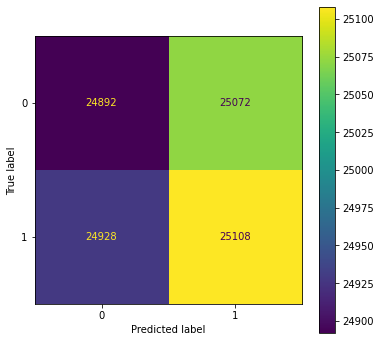

--- ROC AUC ---------------------------------------------------------------------------------------- 



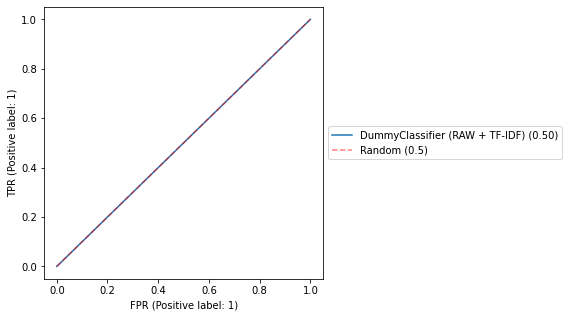

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



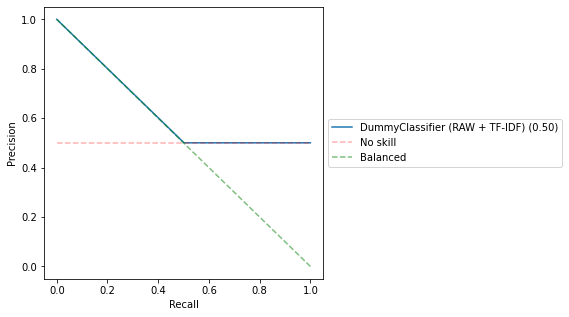

In [11]:
get_scores(model_name, **grd_dummy, register=True, X_ref=X_test, y_ref=y_test)

In [12]:
del grd_dummy

## 2.2 Essayons un algorithme linéaire - Logistic Regression <a class="anchor" id="CLF_logreg"></a> [⇪](#menu)

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
from scipy.stats import uniform, loguniform

In [15]:
max_lr_iter = 3000
param_grid = [
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['saga'],
        'penalty' : ['elasticnet'], # none
        'C' : loguniform(1e-5, 1e2),
        'l1_ratio' : uniform(0,1)
    },
]

In [16]:
model_name = "LogisticRegression (RAW + TF-IDF)"
max_lr_iter = 3000

grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref = X_train,
    y_ref = y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7985
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7962
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7981
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7977
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7967

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7975 (std:0.0010)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression (RAW + TF-IDF) --------------------------------------------------------------

             ROC_AUC : 0.8707
                  F1 : 0.7918
            ACCURACY : 0.7903
           PRECISION : 0.7869
              RECALL : 0.7968
   AVERAGE_PRECISION : 0.8708

       TRAINING-TIME : 224.7449
      INFERENCE-TIME : 0.0476

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.79      0.78      0.79     49964
Prediction = 1       0.79      0.80      0.79     50036

      accuracy                           0.79    100000
     macro avg      

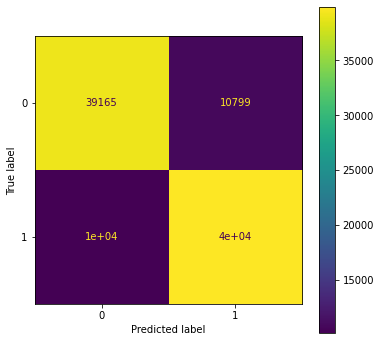

--- ROC AUC ---------------------------------------------------------------------------------------- 



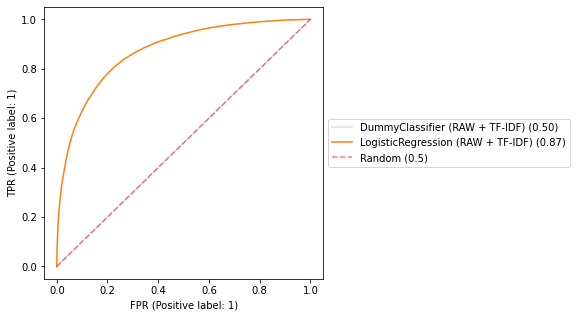

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



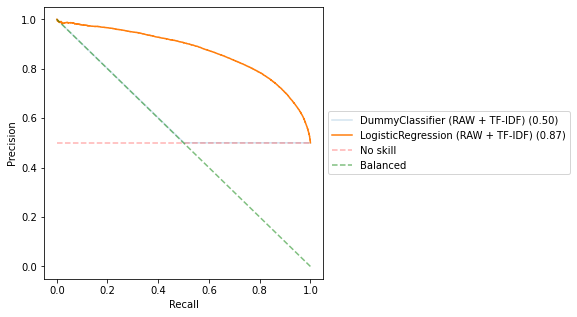

In [17]:
get_scores(model_name, **grd_log, register=True, X_ref=X_test, y_ref=y_test)

---
---
# 3. Recherche du `pré-traitement` le plus adapté <a class="anchor" id="PREPROCESS"></a> [⇪](#menu)

---
## 3.1 TOKENISATION <a class="anchor" id="PREPROCESS_tokenized"></a> [⇪](#menu)

### Nous avons déjà calculé ce modèle, donc nous n'allons pas le refaire, mais nous pouvons afficher les résultats une seconde fois

/home/valkea/Dev/OpenClassrooms/Projets_AI/P7/venvP7/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression (RAW + TF-IDF) --------------------------------------------------------------

             ROC_AUC : 0.8707
                  F1 : 0.7918
            ACCURACY : 0.7903
           PRECISION : 0.7869
              RECALL : 0.7968
   AVERAGE_PRECISION : 0.8708

       TRAINING-TIME : 224.7449
      INFERENCE-TIME : 0.0107

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.79      0.78      0.79     49964
Prediction = 1       0.79      0.80      0.79     50036

      accuracy                           0.79    100000
     macro avg      

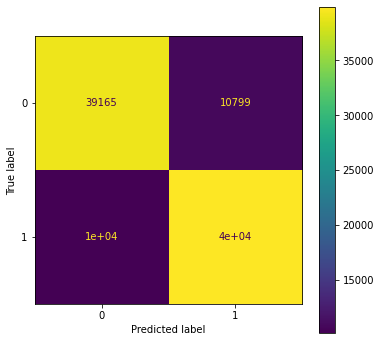

--- ROC AUC ---------------------------------------------------------------------------------------- 



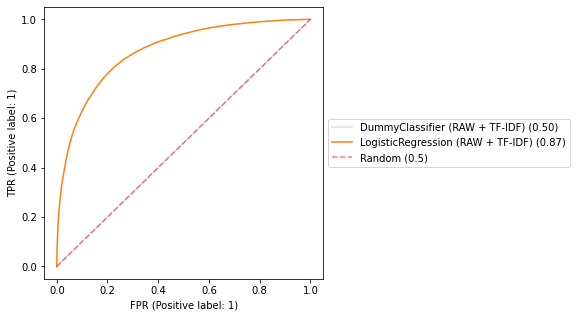

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



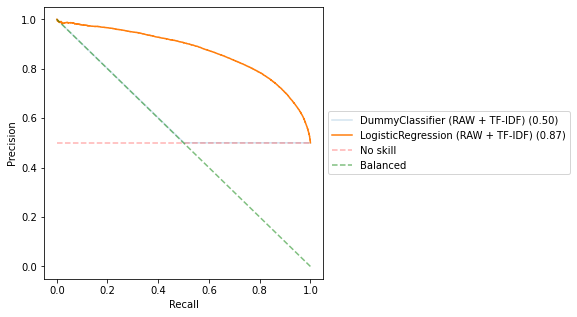

In [18]:
get_scores(model_name, **grd_log, register=True, X_ref=X_test, y_ref=y_test)

---
## 3.2 TOKENISATION + FILTRAGE <a class="anchor" id="PREPROCESS_filtered"></a> [⇪](#menu)

### Chargeons et appliquons le pré-traitement sur le jeu de données tokenisé & filtré

In [19]:
data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_filtered.bin')
data_nlp = joblib.load(data_nlp_path)

In [20]:
display(data_nlp.head(2), data_nlp.shape)

,tokens_filtered,target
1180586,"[omg, yes, yes, yes, watching]",1
1471360,"[excuse, wii]",1


(456560, 2)

In [21]:
X_train, X_test, y_train, y_test, tfidf_vectorizer_train = preprocess_data(data_nlp, 'tokens_filtered', test_size=0.2)

DataFrames shapes >> df_train: (365248,), df_test:(91312,), y_train:(365248,), y_test:(91312,)
Corpus preview: ['starting feel good promised deliver stuff cob today', 'sad coz join frenz picnic']
TF-IDF features: ['aa' 'aaa' 'aaaa' ... 'zzzzzzzzzz' 'ðº' 'ðºð']
Sets shapes >> X_train: (365248, 18419), X_test: (91312, 18419)


### Appliquons la Logistic Regression avec ce jeu de données

In [22]:
model_name = "LogisticRegression (FILTERED + TF-IDF)"
max_lr_iter = 3000

grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref = X_train,
    y_ref = y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7686
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7671
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7681
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7666
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7679

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7677 (std:0.0011)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression (FILTERED + TF-IDF) ---------------------------------------------------------

             ROC_AUC : 0.8343
                  F1 : 0.7595
            ACCURACY : 0.7561
           PRECISION : 0.7430
              RECALL : 0.7767
   AVERAGE_PRECISION : 0.8256

       TRAINING-TIME : 111.8823
      INFERENCE-TIME : 0.0105

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.77      0.74      0.75     46044
Prediction = 1       0.74      0.78      0.76     45268

      accuracy                           0.76     91312
     macro avg      

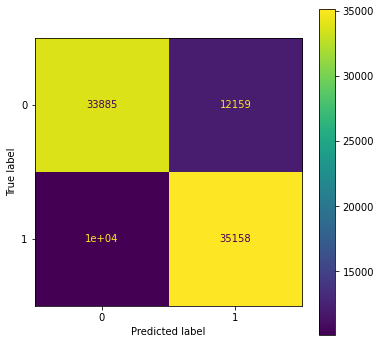

--- ROC AUC ---------------------------------------------------------------------------------------- 



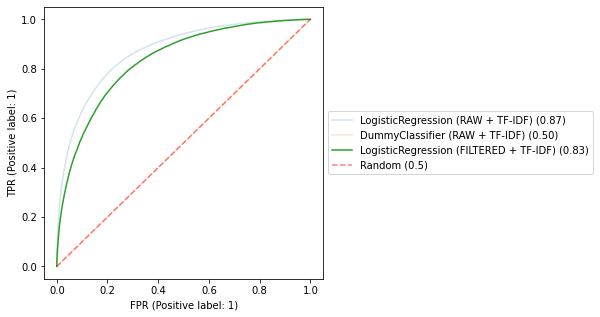

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



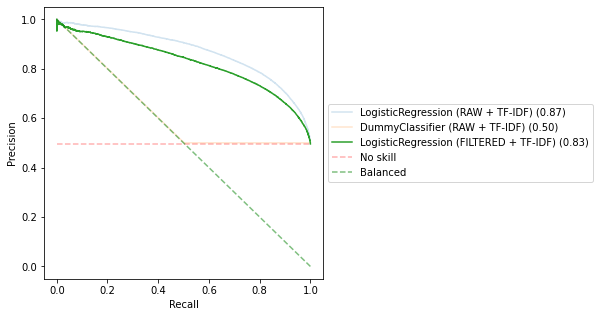

In [23]:
get_scores(model_name, **grd_log, register=True, X_ref=X_test, y_ref=y_test)

---
## 3.3 TOKENISATION + FILTRAGE + LEMMATIZATION <a class="anchor" id="PREPROCESS_lemmatized"></a> [⇪](#menu)

### Chargeons et appliquons le pré-traitement sur le jeu de données tokenisé & filtré & lemmatisé

In [24]:
data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_lemmas.bin')
data_nlp_lemmas = joblib.load(data_nlp_path)

In [25]:
display(data_nlp_lemmas.head(2), data_nlp_lemmas.shape)

,lemmas,target
1180586,"[omg, yes, yes, yes, watch]",1
1471360,"[excuse, wii]",1


(456560, 2)

In [26]:
X_train, X_test, y_train, y_test, tfidf_vectorizer_train = preprocess_data(data_nlp_lemmas, 'lemmas', test_size=0.2)

DataFrames shapes >> df_train: (365248,), df_test:(91312,), y_train:(365248,), y_test:(91312,)
Corpus preview: ['start feel good promise deliver stuff cob today', 'sad coz join frenz picnic']
TF-IDF features: ['aa' 'aaa' 'aaaa' ... 'zzzzzzzzzz' 'ðº' 'ðºð']
Sets shapes >> X_train: (365248, 14864), X_test: (91312, 14864)


### Appliquons la Logistic Regression avec ce jeu de données

In [27]:
model_name = "LogisticRegression (LEMMATIZED + TF-IDF)"
max_lr_iter = 3000

grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref = X_train,
    y_ref = y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7684
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7668
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7682
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7661
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7686

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7676 (std:0.0011)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression (LEMMATIZED + TF-IDF) -------------------------------------------------------

             ROC_AUC : 0.8291
                  F1 : 0.7537
            ACCURACY : 0.7502
           PRECISION : 0.7372
              RECALL : 0.7711
   AVERAGE_PRECISION : 0.8206

       TRAINING-TIME : 100.7196
      INFERENCE-TIME : 0.0095

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.76      0.73      0.75     46044
Prediction = 1       0.74      0.77      0.75     45268

      accuracy                           0.75     91312
     macro avg      

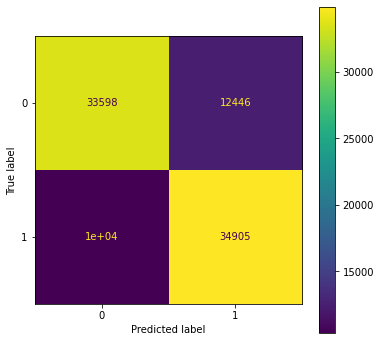

--- ROC AUC ---------------------------------------------------------------------------------------- 



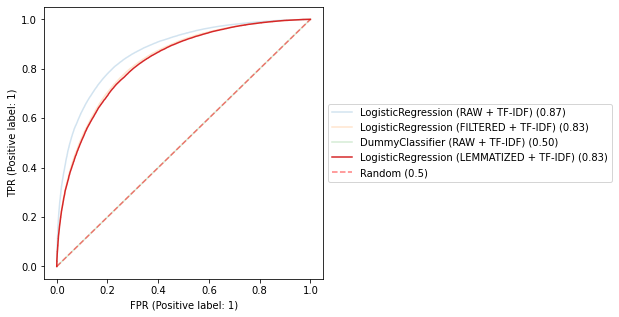

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



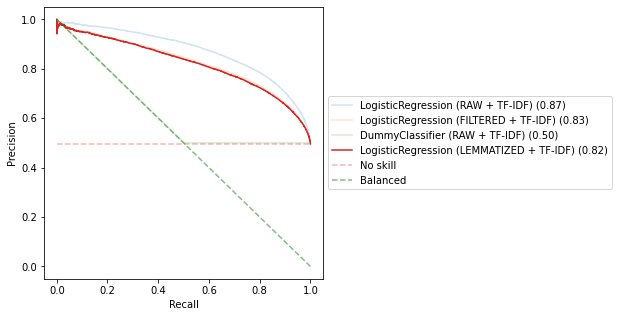

In [28]:
get_scores(model_name, **grd_log, register=True, X_ref=X_test, y_ref=y_test)

---
## 3.4 Comparaison des `scores` <a class="anchor" id="PREPROCESS_scores"></a> [⇪](#menu)

>#### Les scores ci-dessous ont été obtenus avec divers pré-traitements initiaux
> mais la phase final de pré-traitement à dans tous les cas utilisé **TF-IDF** comme moyen de rendre compatible les textes avec le DummyClassifier et la LogisticRegression.

In [29]:
from classification_utils import scores_df

In [30]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,DummyClassifier (RAW + TF-IDF),None,"{'random_state': [0], 'strategy': ['stratified']}",0.499999,0.500359,0.501078,0.500000,0.500359,0.501799,25108,24892,25072,24928,1.488744,0.009888
1,LogisticRegression (RAW + TF-IDF),None,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.870716,0.870764,0.791782,0.790320,0.786859,0.796766,39867,39165,10799,10169,224.744926,0.010728
2,LogisticRegression (FILTERED + TF-IDF),None,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.834262,0.825633,0.759475,0.756122,0.743031,0.776663,35158,33885,12159,10110,111.882335,0.010462
3,LogisticRegression (LEMMATIZED + TF-IDF),None,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.829117,0.820638,0.753733,0.750208,0.737154,0.771074,34905,33598,12446,10363,100.719613,0.009465
